In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import map_coordinates, gaussian_filter
import time


In [2]:
# Constants
DELTA_T = 0.1
NUM_STEPS = 10
SIGMA_DEFAULT = 1.0


In [3]:
def load_data():
    """
    Load the initial velocity field and source image.

    Returns:
        velocity (ndarray): Initial velocity field of shape (2, 100, 100).
        source_image (ndarray): Source image of shape (100, 100).
    """
    velocity = torch.load('v0.pt').numpy()  # Initial velocity field (2, 100, 100)
    print("Dimension of velocity V0:", velocity.shape)
    source = torch.load('source.pt').numpy()  # Source image (100, 100)
    print("Dimension of image:", source.shape)
    source_image = source  # Use the source directly since it's already (100, 100)
    return velocity, source_image


In [4]:
def display_image(image, title='Image', cmap='gray'):
    """
    Display a single image.

    Args:
        image (ndarray): Image to display.
        title (str): Title of the image.
        cmap (str): Colormap to use for displaying the image.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [5]:
def central_difference_x(u):
    """Compute the central difference approximation of the derivative in the x-direction."""
    return (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1)) / 2.0


In [6]:
def central_difference_y(u):
    """Compute the central difference approximation of the derivative in the y-direction."""
    return (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0)) / 2.0


In [7]:
def geodesic_shooting(v_t_initial, source_image, delta_t=DELTA_T, num_steps=NUM_STEPS, sigma=SIGMA_DEFAULT):
    """
    Perform geodesic shooting with the given initial velocity field.

    Args:
        v_t_initial (ndarray): Initial velocity field of shape (2, img_rows, img_cols).
        source_image (ndarray): Source image of shape (img_rows, img_cols).
        delta_t (float): Time step size.
        num_steps (int): Number of time steps to perform.
        sigma (float): Standard deviation for Gaussian smoothing.

    Returns:
        v_t (ndarray): Final velocity field after geodesic shooting.
        phi_t (ndarray): Final deformation field.
        deformed_images (list): List of deformed images at each time step.
        total_time (float): Total computation time in seconds.
    """
    # Initialize variables
    img_rows, img_cols = source_image.shape
    x = np.arange(img_cols)
    y = np.arange(img_rows)
    X, Y = np.meshgrid(x, y)
    phi_t = np.array([X, Y])  # Deformation field (2, img_rows, img_cols)
    v_t = v_t_initial.copy()
    deformed_images = []
    start_time = time.time()

    for step in range(num_steps):
        # Extract velocity components
        v_x = v_t[0]
        v_y = v_t[1]

        # Compute spatial derivatives
        dvx_dx = central_difference_x(v_x)
        dvx_dy = central_difference_y(v_x)
        dvy_dx = central_difference_x(v_y)
        dvy_dy = central_difference_y(v_y)

        # Compute divergence
        div_v_t = dvx_dx + dvy_dy

        # Compute (D v_t)^T ⋅ v_t
        term1_x = dvx_dx * v_x + dvy_dx * v_y
        term1_y = dvx_dy * v_x + dvy_dy * v_y

        # Compute (D v_t) ⋅ v_t
        term2_x = dvx_dx * v_x + dvx_dy * v_y
        term2_y = dvy_dx * v_x + dvy_dy * v_y

        # Compute v_t ⋅ div(v_t)
        term3_x = v_x * div_v_t
        term3_y = v_y * div_v_t

        # Sum terms
        dv_t_terms_x = term1_x + term2_x + term3_x
        dv_t_terms_y = term1_y + term2_y + term3_y

        # Apply Gaussian smoothing kernel K
        dv_t_terms_x_smoothed = gaussian_filter(dv_t_terms_x, sigma=sigma)
        dv_t_terms_y_smoothed = gaussian_filter(dv_t_terms_y, sigma=sigma)

        # Compute dv_t/dt
        dv_t_dt_x = -dv_t_terms_x_smoothed
        dv_t_dt_y = -dv_t_terms_y_smoothed

        # Update velocity field
        v_t[0] = v_x + delta_t * dv_t_dt_x
        v_t[1] = v_y + delta_t * dv_t_dt_y

        # Interpolate velocity at phi_t to compute dphi_t/dt
        coords = [phi_t[1], phi_t[0]]  # Coordinates are (rows, cols)
        v_x_at_phi = map_coordinates(v_t[0], coords, order=3, mode='nearest')
        v_y_at_phi = map_coordinates(v_t[1], coords, order=3, mode='nearest')

        # Update deformation field
        phi_t[0] = phi_t[0] + delta_t * v_x_at_phi
        phi_t[1] = phi_t[1] + delta_t * v_y_at_phi

        # Deform the source image
        deformed_coords = [phi_t[1], phi_t[0]]  # Coordinates for interpolation
        s_deformed = map_coordinates(source_image, deformed_coords, order=3, mode='nearest')
        deformed_images.append(s_deformed)

    end_time = time.time()
    total_time = end_time - start_time

    return v_t, phi_t, deformed_images, total_time


In [8]:
def display_velocity_components(v_t_final, sigma):
    """
    Display final velocity components in a single figure with subplots.

    Args:
        v_t_final (ndarray): Final velocity field after geodesic shooting.
        sigma (float): Standard deviation used in Gaussian smoothing.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    im0 = axes[0].imshow(v_t_final[0], cmap='jet')
    axes[0].set_title(f'Final v_x (σ={sigma})')
    axes[0].axis('off')
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(v_t_final[1], cmap='jet')
    axes[1].set_title(f'Final v_y (σ={sigma})')
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1])

    plt.tight_layout()
    plt.show()
    

In [9]:
def display_deformed_images(deformed_images, delta_t, sigma, ncols=5):
    """
    Display deformed images in a grid.

    Args:
        deformed_images (list): List of deformed images.
        delta_t (float): Time step size.
        sigma (float): Standard deviation used in Gaussian smoothing.
        ncols (int): Number of columns for the grid display.
    """
    num_images = len(deformed_images)
    nrows = (num_images + ncols - 1) // ncols  # Ceiling division to get number of rows

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6))
    axes = axes.flatten()  # Flatten in case nrows or ncols is 1

    for idx, img in enumerate(deformed_images):
        ax = axes[idx]
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Deformed Image: t={delta_t * (idx + 1):.1f}, σ={sigma}')
        ax.axis('off')

    # Hide any unused subplots
    for idx in range(len(deformed_images), nrows * ncols):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


In [10]:
def report_total_time(total_time):
    """
    Report the total running time of the shooting algorithm.

    Args:
        total_time (float): Total computation time in seconds.
    """
    print(f"Total running time of the shooting algorithm: {total_time:.4f} seconds")


In [11]:
def random_velocity_field_simulation(source_image, variances):
    """
    Generate random initial velocity fields and repeat the geodesic shooting.

    Args:
        source_image (ndarray): Source image.
        variances (list): List of variances for Gaussian smoothing.
    """
    img_rows, img_cols = source_image.shape

    for sigma in variances:
        print(f"\nRepeating with Gaussian smoothing variance: {sigma}")
        # Compute gradient of the source image
        grad_s_x = central_difference_x(source_image)
        grad_s_y = central_difference_y(source_image)

        # Generate random velocity field epsilon
        epsilon_x = np.random.normal(size=(img_rows, img_cols))
        epsilon_y = np.random.normal(size=(img_rows, img_cols))

        # Multiply epsilon with gradient of source image
        v0_x = epsilon_x * grad_s_x
        v0_y = epsilon_y * grad_s_y

        # Combine velocity components
        v0 = np.array([v0_x, v0_y])

        # Apply Gaussian smoothing to the initial velocity field
        v0_smoothed_x = gaussian_filter(v0[0], sigma=sigma)
        v0_smoothed_y = gaussian_filter(v0[1], sigma=sigma)
        v0_smoothed = np.array([v0_smoothed_x, v0_smoothed_y])

        # Perform geodesic shooting with the new initial velocity
        v_t_final, phi_t_final, deformed_images, total_time = geodesic_shooting(
            v0_smoothed, source_image, sigma=SIGMA_DEFAULT
        )

        # Report final velocity in subplots
        display_velocity_components(v_t_final, sigma)

        # Display deformed images in a grid
        display_deformed_images(deformed_images, DELTA_T, sigma)


Dimension of velocity V0: (2, 100, 100)
Dimension of image: (100, 100)


/var/folders/cw/r29c7jk96kz5c6cdh1bry6nc0000gn/T/ipykernel_72379/1990495681.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  velocity = torch.load('v0.pt').numpy()  # Ini

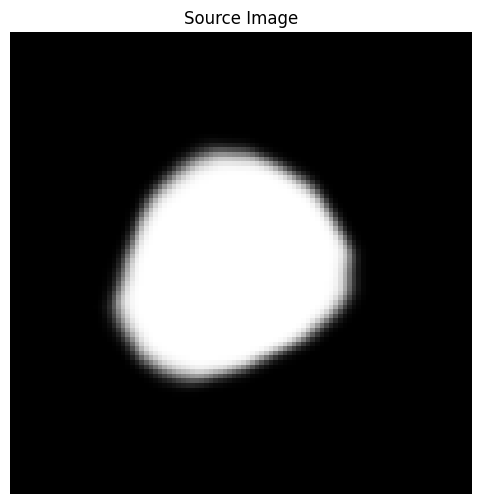

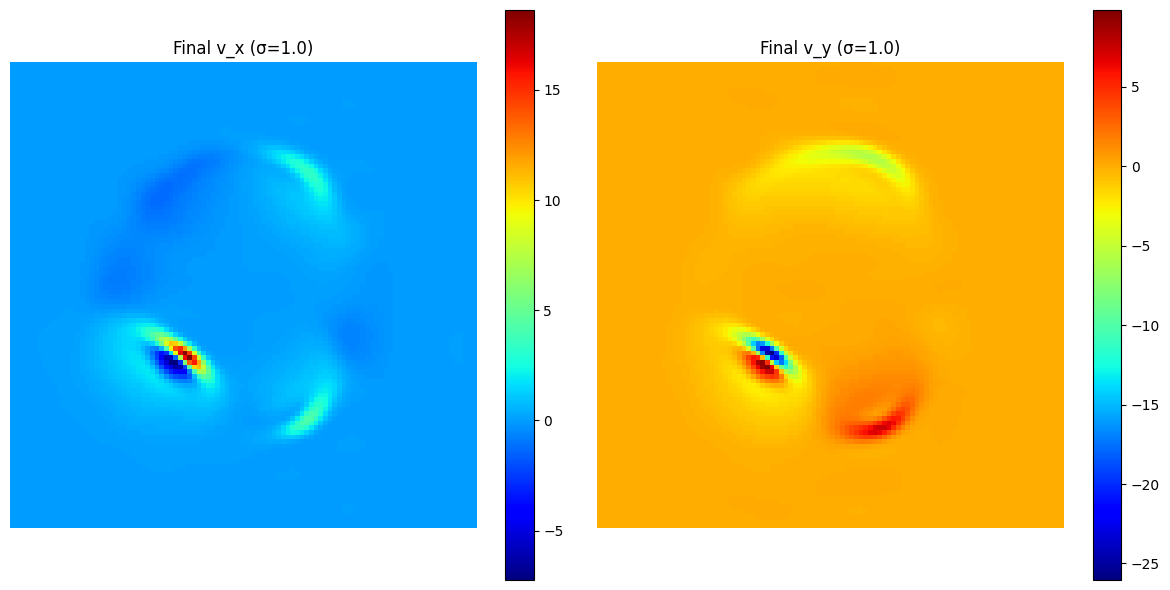

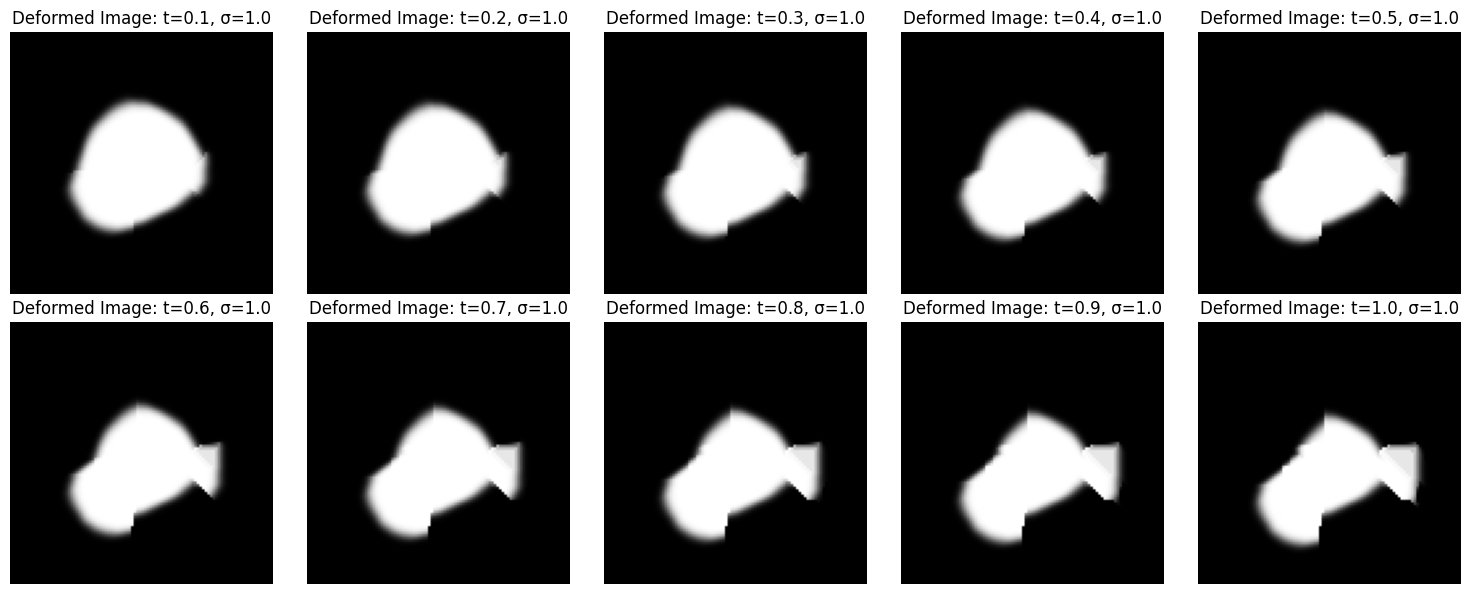

Total running time of the shooting algorithm: 0.0358 seconds

Repeating with Gaussian smoothing variance: 2.0


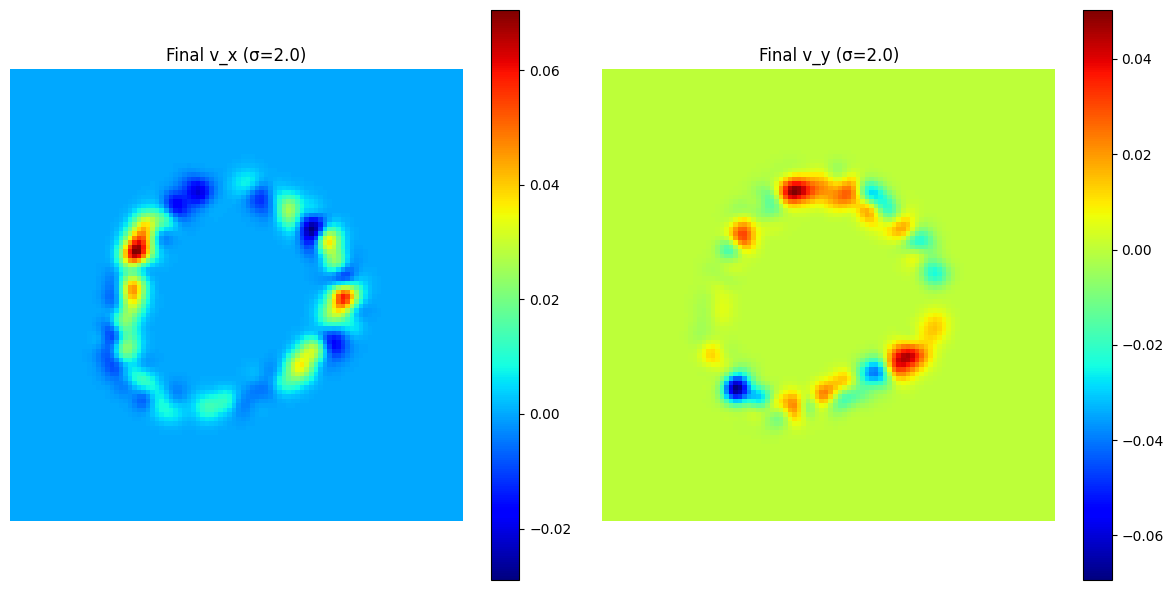

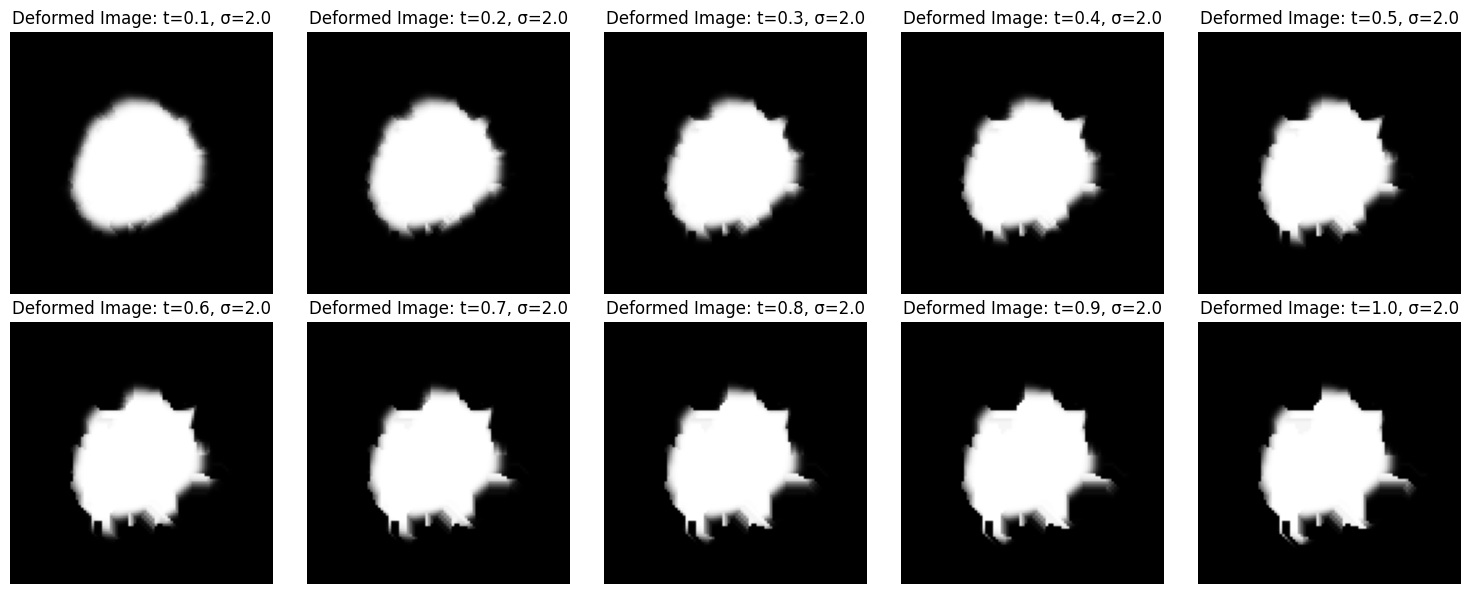


Repeating with Gaussian smoothing variance: 4.0


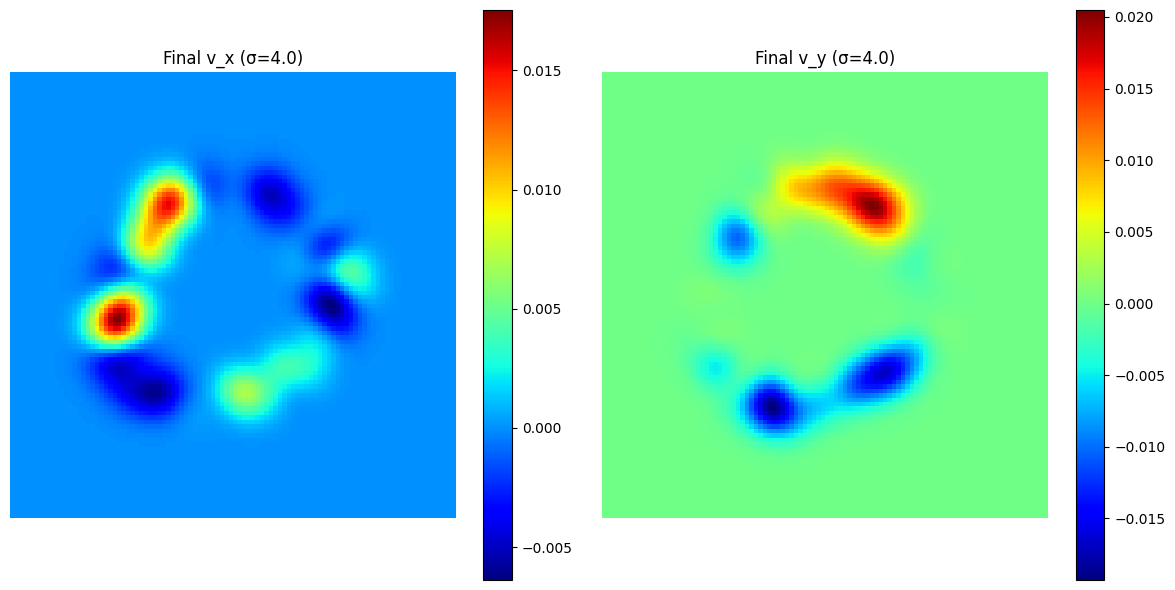

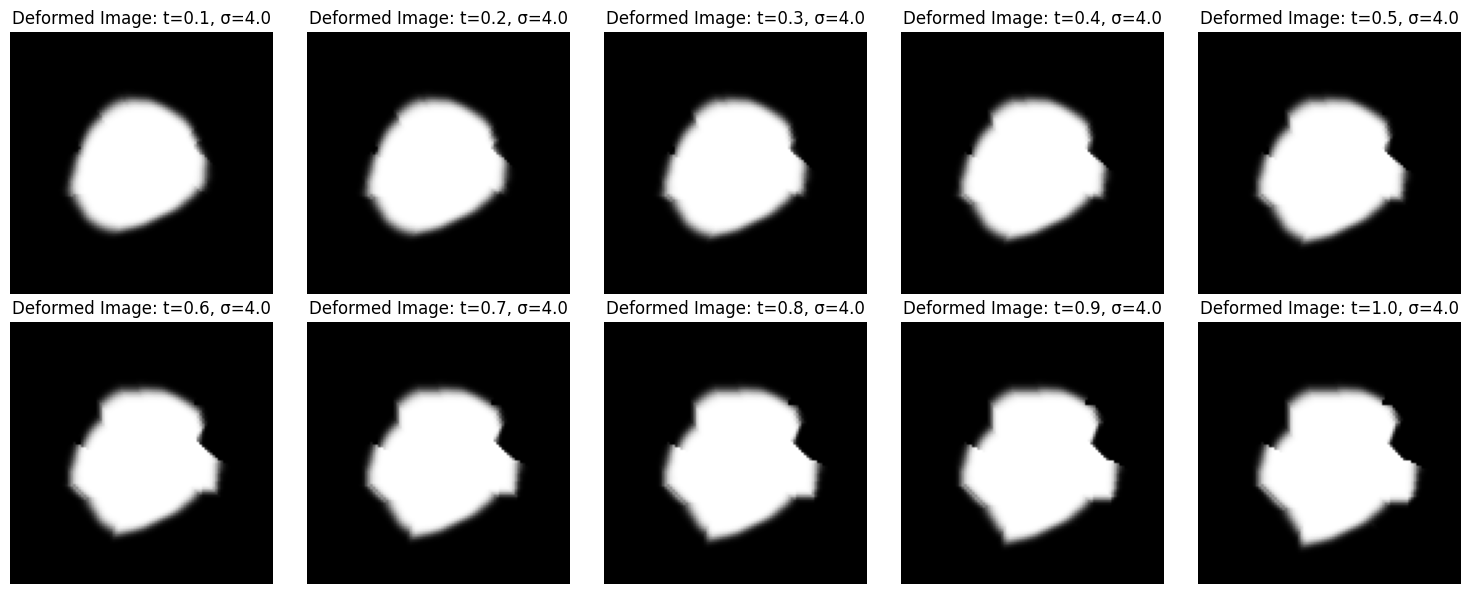


Repeating with Gaussian smoothing variance: 8.0


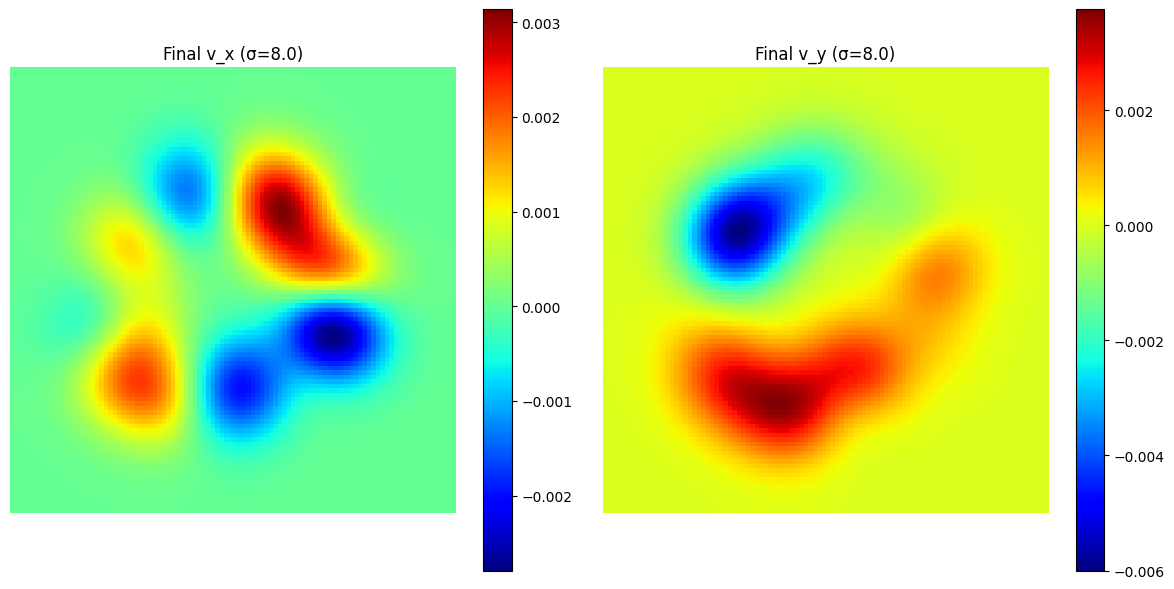

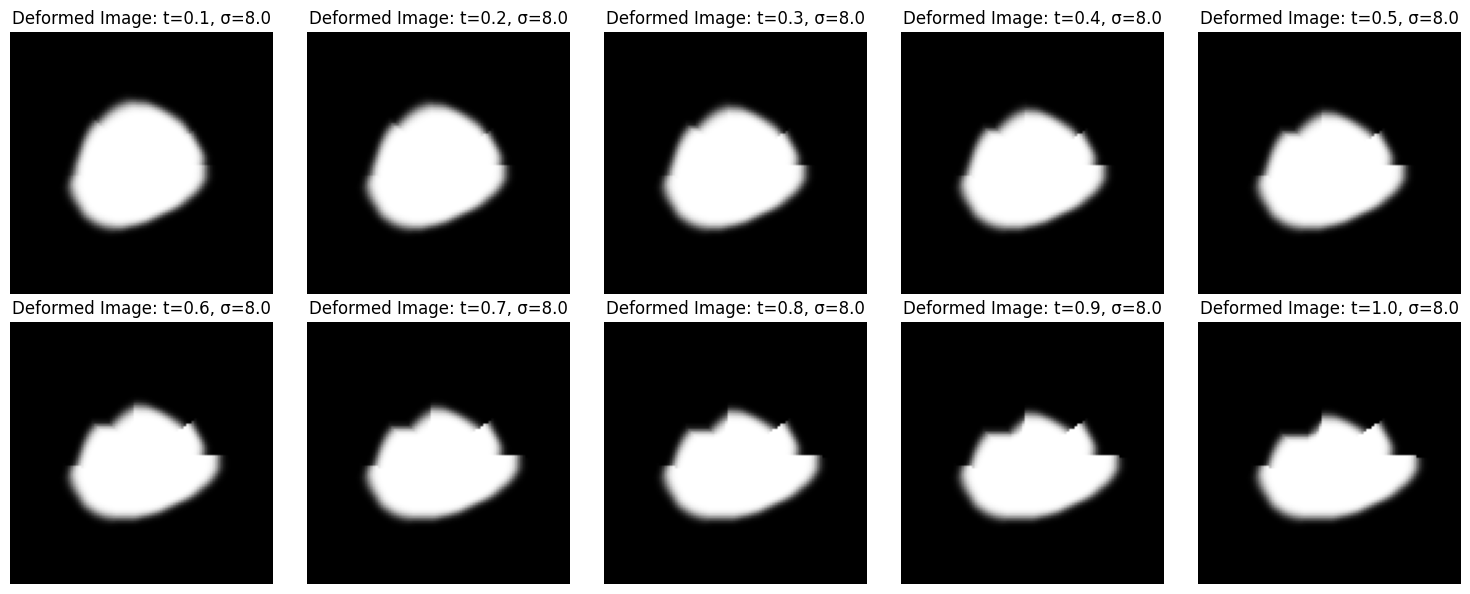

In [12]:
def main():
    # Load data
    velocity, source_image = load_data()

    # Display the source image
    display_image(source_image, title='Source Image')

    # Implement and compute the geodesic shooting equation
    v_t_final, phi_t_final, deformed_images, total_time = geodesic_shooting(velocity, source_image)

    # Report the final velocity and time-sequence of deformed images
    sigma = SIGMA_DEFAULT
    display_velocity_components(v_t_final, sigma)
    display_deformed_images(deformed_images, DELTA_T, sigma)

    # Report the total running time
    report_total_time(total_time)

    # Generate random initial velocity fields and repeat
    variances = [2.0, 4.0, 8.0]
    random_velocity_field_simulation(source_image, variances)

if __name__ == "__main__":
    main()
